In [1]:
import numpy as np
import torch
import warnings

warnings.filterwarnings(action='ignore')
torch.manual_seed(59)

### Previous code (Data)

In [4]:
from torchvision import datasets, transforms

data_path = 'data\\cifar\\'
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize(
                                               (0.4914, 0.4822, 0.4465),
                                               (0.247, 0.2435, 0.2616)
                                           )
                                       ]))

transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                                           transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize(
                                                   (0.4914, 0.4822, 0.4465),
                                                   (0.247, 0.2435, 0.2616)
                                                   )
                                               ]))

In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label])
          for img, label in transformed_cifar10
          if label in (0, 2)]

cifar2_val = [(img, label_map[label])
              for img, label in transformed_cifar10_val
              if label in (0, 2)]

### Convolutions

In [6]:
from torch import nn

conv = nn.Conv2d(3, 16, kernel_size=3)  # 3 channels, 16 output channels, 3x3 kernel size
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

So the weight is `num_out_channels x num_input_channels x kernel_size x kernel_size`, the bias is unique for every channel, but in channel stays the same

In [7]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [8]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

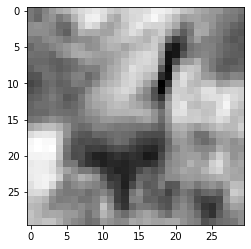

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

With padding

In [10]:
from black import out


conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [11]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0 / 9.0)

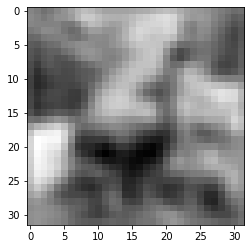

In [12]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

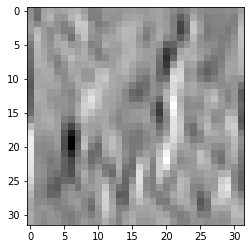

In [14]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

### Pooling (MaxPooling2D)

In [15]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

### Convolutions + Pooling in Birds & Airplanes

In [16]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),   # only recently - flattens the matrix into 1D Vector
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [17]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [19]:
model(img.unsqueeze(0))

tensor([[0.1164, 0.0974]], grad_fn=<AddmmBackward0>)

### nn.Module

When we need smth more complex than nn.Sequential.

For example there was no `Flatten` layer earlier, so if we built such a network earlier, we would have to use `nn.Module`.

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        # Reshape instead of `Flatten`, -1 num of batches
        x = x.view(-1, 8 * 8 * 8)
        x = self.act3(self.fc1(x))
        out = self.fc2(x)
        return out

In [21]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

### Functional API (more customization)

Keep only layers that are being trained (`nn.Conv2D`, `nn.Linear`). But other layers (activation such as `tanh`, `maxpooling`) we can call from `functional`, as they have no parameters.

In [24]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = F.max_pool2d(F.tanh(self.conv1(x)), 2)  # can also be torch.tanh
        x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)
        x = x.view(-1, 8 * 8 * 8)
        x = F.tanh(self.fc1(x))
        out = self.fc2(x)
        return out

There is one style matter that will help you avoid surprises with (originally unforeseen) uses: if you need several applications of stateless modules (like `nn.HardTanh` or `nn.ReLU`), it is probably a good idea to have a `separate instance` for each. Reusing the same module appears to be clever and will give correct results with our standard Python usage here, but tools analyzing your model may trip over it.

In [26]:
# Fast check
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.2644, -0.2012]], grad_fn=<AddmmBackward0>)